In [1]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import TransformerMixin
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import seaborn as sns
import math
import urllib.request as urllib

In [2]:
def GetDataLocally(url,file_name,skipFirstLine=False, skipLastLine=False, oper='wb'):

    """Download URL files"""

    dsfile = urllib.urlopen(url)
    lines=dsfile.readlines()
  
    if skipFirstLine:
        lines = lines[1:]
    if skipLastLine:
        lines = lines[:-1]
    with open(file_name,oper) as output:
        output.writelines(lines)
    return

class DataImputer(TransformerMixin):
    """
    Imputes missing values:
        - dtype object : imputed with the most frequent value
        - dtype others : imputed with mean of column
    """
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
def num_encoder(df):
    """
    Encodes categorical features as numbers
    
    """
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
            encoders[column].fit_transform(result[column])
    return result, encoders

# Download Adult Income Training and Test Datasets

In [4]:
# Download Training Data
FILE_NAME='adult.data'
DATA_URI = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
GetDataLocally(DATA_URI,FILE_NAME,False,True,'wb')

# Download Test Data
FILE_NAME='adult.test'
DATA_URI = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
GetDataLocally(DATA_URI,FILE_NAME,True,True,'wb')

# Load Datasets

In [4]:
#Load Training Dataset with missing values
training_data = pd.read_csv(
    'adult.data',
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="-1")

#Load Test Dataset
test_data = pd.read_csv(
    'adult.test',
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="-1")

#Load Training Dataset with ? considered as NaN
training_data_imputed = pd.read_csv(
    'adult.data',
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

# Data Pre-processing and Analysis

In [5]:
# Removing DOTs in Target column
training_data['Target'] = training_data['Target'].map(lambda x: x.rstrip('.'))
training_data_imputed['Target'] = training_data_imputed['Target'].map(lambda x: x.rstrip('.'))
test_data['Target'] = test_data['Target'].map(lambda x: x.rstrip('.'))

# Finding average Capital Gain when Capital Gain != 99999 
df = training_data[training_data['Capital Gain'] != 99999]
mean_cap_gain = math.ceil(df['Capital Gain'].mean(axis=0))

# Replaceing 99999 values with mean capital gain values
# training_data['Capital Gain'].replace(99999,mean_cap_gain,inplace=True)
# training_data_imputed['Capital Gain'].replace(99999,mean_cap_gain,inplace=True)

# df = test_data[test_data['Capital Gain'] != 99999]
# mean_cap_gain = math.ceil(df['Capital Gain'].mean(axis=0))
# test_data['Capital Gain'].replace(99999,mean_cap_gain,inplace=True)

training_data.loc[training_data.Workclass == 'Never-worked', 'Hours per week'] = 0
training_data_imputed.loc[training_data_imputed.Workclass == 'Never-worked', 'Hours per week'] = 0
test_data.loc[test_data.Workclass == 'Never-worked', 'Hours per week'] = 0

# Labelling '?' (missing values) with 'Missing' in both Training and Test datasets
training_data.replace('?','Missing',inplace=True)
test_data.replace('?','Missing',inplace=True)

# Imputing Missing Values in separate training dataset 
training_data_imputed = DataImputer().fit_transform(training_data_imputed)

# training_data.to_csv('adult_training.csv')
# training_data_imputed.to_csv('adult_training_imputed.csv')
# test_data.to_csv('adult_test.csv')

## Remove Records With Missing Values

In [6]:
# training_data = training_data[training_data.Workclass != 'Missing']
# test_data = test_data[test_data.Workclass != 'Missing']

# training_data = training_data[training_data.Occupation != 'Missing']
# test_data = test_data[test_data.Occupation != 'Missing']

# training_data = training_data[training_data.Country != 'Missing']
# test_data = test_data[test_data.Country != 'Missing']

# print(training_data.shape)
# print(test_data.shape)

## Further Dataset Exploration

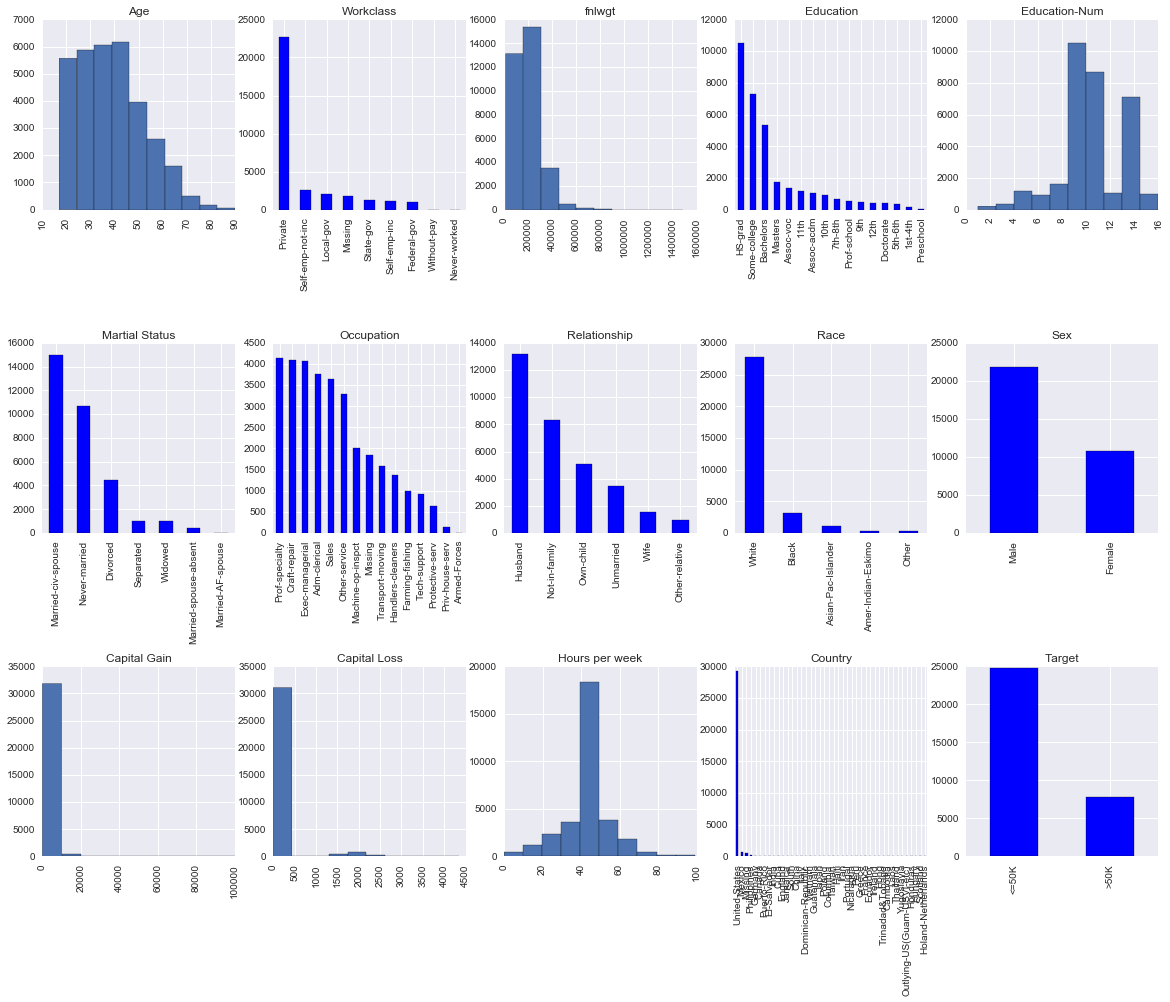

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(training_data.shape[1]) / cols)
for n, column_name in enumerate(training_data.columns):
    ax = fig.add_subplot(rows, cols, n + 1)
    ax.set_title(column_name)
    if training_data.dtypes[column_name] == np.object:
        training_data[column_name].value_counts().plot(kind="bar", axes=ax)
    else:
        training_data[column_name].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [8]:
print((training_data["Country"].value_counts() / training_data.shape[0]).head())

United-States    0.895857
Mexico           0.019748
Missing          0.017905
Philippines      0.006081
Germany          0.004207
Name: Country, dtype: float64


## Correlation Analysis

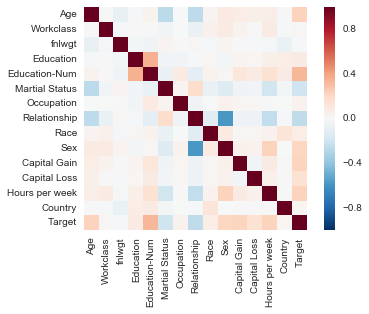

In [9]:
# Calculate the correlation and plot it
encoded_training_data, _ = num_encoder(training_data)
# encoded_training_data_imputed, _ = num_encoder(training_data_imputed)
# encoded_test_data, _ = num_encoder(test_data)

sns.heatmap(encoded_training_data.corr(), square=True)
plt.show()


In [10]:
"""
Strong Correlation exists between Education and Education-Num. Education-Num is numerical representation of Education. 
Deleting column Education.
"""
training_data[["Education", "Education-Num"]].head(15)

del training_data["Education"]
del training_data_imputed["Education"]
del test_data["Education"]

In [11]:
training_data[["Sex", "Relationship"]].head(15)

,Sex,Relationship
0,Male,Not-in-family
1,Male,Husband
2,Male,Not-in-family
3,Male,Husband
4,Female,Wife
5,Female,Wife
6,Female,Not-in-family
7,Male,Husband
8,Female,Not-in-family
9,Male,Husband


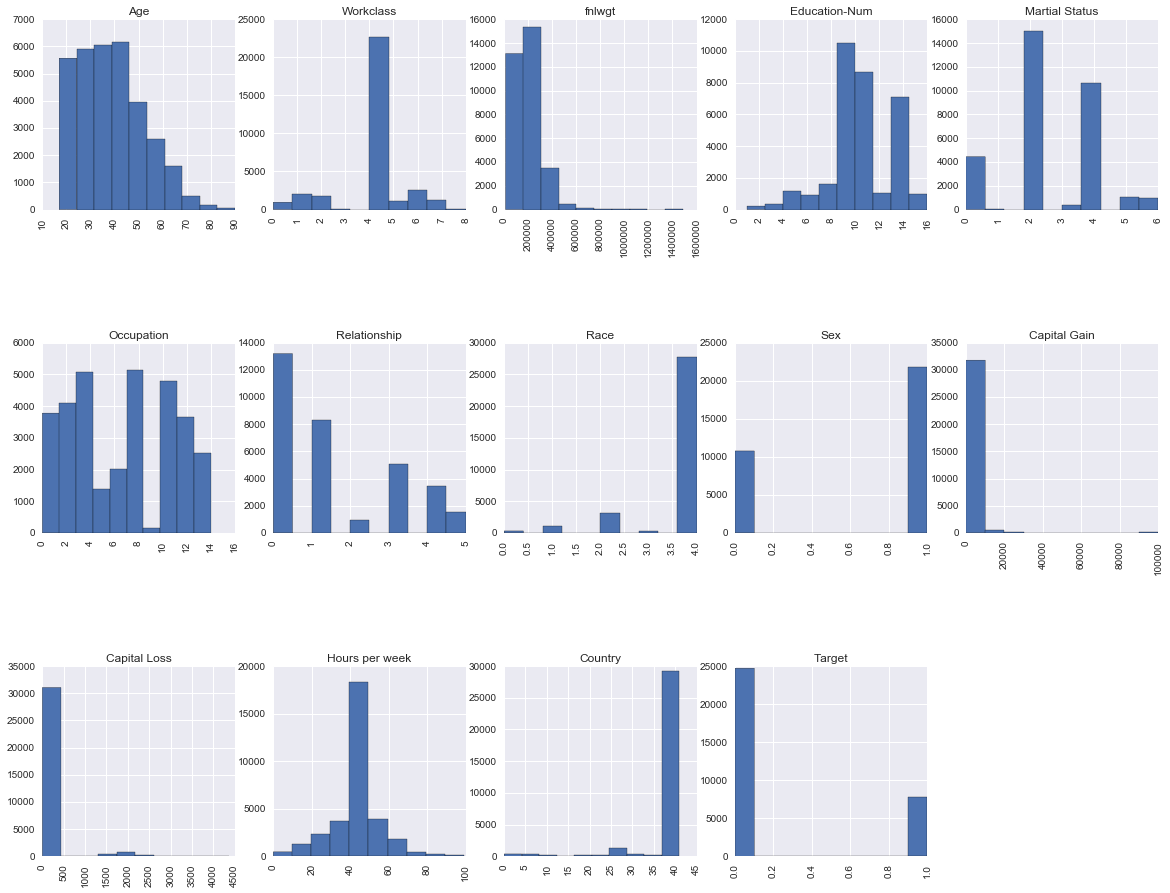

In [12]:
%matplotlib inline
encoded_training_data, training_encoders = num_encoder(training_data)
encoded_training_data_imputed, training_imputed_encoders = num_encoder(training_data_imputed)
encoded_test_data, test_encoders = num_encoder(test_data)

fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_training_data.shape[1]) / cols)
for i, column_name in enumerate(encoded_training_data.columns):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(column_name)
    encoded_training_data[column_name].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)



## Removing mean and scaling to unit variance

In [13]:
X_train = encoded_training_data[encoded_training_data.columns - ["Target"]]
y_train = encoded_training_data["Target"]

X_test = encoded_test_data[encoded_training_data.columns - ["Target"]]
X_test2 = encoded_test_data[encoded_training_data.columns - ["Target"]]
y_test = encoded_test_data["Target"]

X_train_imputed = encoded_training_data_imputed[encoded_training_data_imputed.columns - ["Target"]]
y_train_imputed = encoded_training_data_imputed["Target"]

scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

scaler = preprocessing.StandardScaler()
X_train_imputed = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns)
X_test_imputed = scaler.transform(X_test2)

C:\Users\mfarh\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':
C:\Users\mfarh\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
C:\Users\mfarh\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
C:\Users\mfarh\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


# MODEL EVALUATION

## LOGISTIC REGRESSION

### Using GridSearch with Logistic Regression for parameter tuning

In [26]:
"""
Tuning penalty and C with cv=5
"""
# tuned_parameters = [{'penalty':['l2'], 'C': [1, 10, 100, 1000],'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}]
tuned_parameters = [{'penalty':['l1','l2'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(linear_model.LogisticRegression(), tuned_parameters, cv=5)
t1=time()
clf.fit(X_train, y_train)
print('Time Taken to fit: {}s'.format(time()-t1))
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

Time Taken to fit: 4.303830146789551s
Best parameters set found on development set:

{'penalty': 'l2', 'C': 10}

Grid scores on development set:

0.825 (+/-0.004) for {'penalty': 'l1', 'C': 1}
0.825 (+/-0.004) for {'penalty': 'l2', 'C': 1}
0.825 (+/-0.004) for {'penalty': 'l1', 'C': 10}
0.825 (+/-0.004) for {'penalty': 'l2', 'C': 10}
0.825 (+/-0.004) for {'penalty': 'l1', 'C': 100}
0.825 (+/-0.004) for {'penalty': 'l2', 'C': 100}
0.825 (+/-0.004) for {'penalty': 'l1', 'C': 1000}
0.825 (+/-0.004) for {'penalty': 'l2', 'C': 1000}


F1 score: 0.546987
Accuracy score: 0.825011
Precision score: 0.704052
Recall: 0.447218


C:\Users\mfarh\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


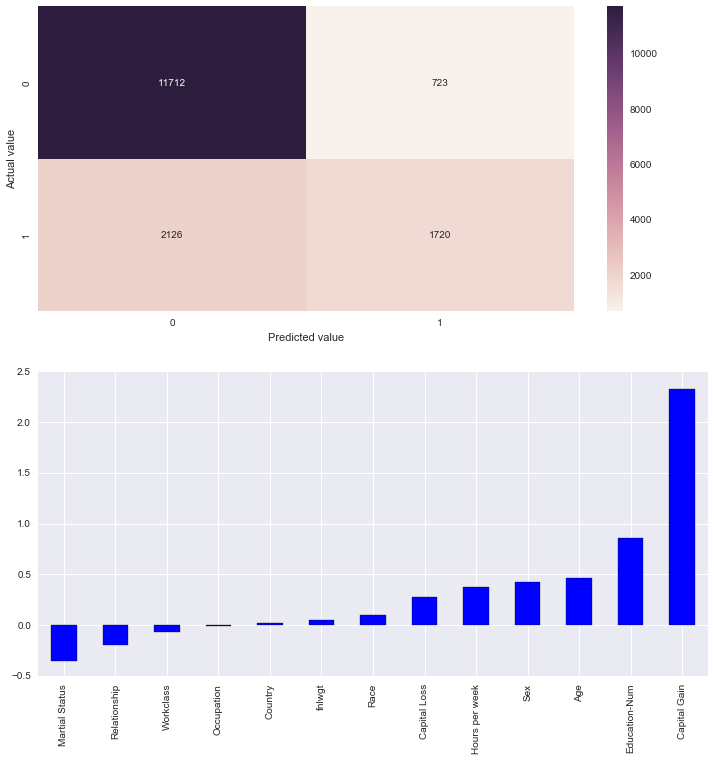

In [53]:
clf = linear_model.LogisticRegression(penalty='l2', C=10.0)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cmat = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cmat, annot=True, fmt="d", xticklabels=training_encoders["Target"].classes_, yticklabels=training_encoders["Target"].classes_)
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
print("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print("Recall: %f" % skl.metrics.recall_score(y_test, y_pred))
coeffs = pd.Series(clf.coef_[0], index=X_train.columns)
coeffs.sort()
plt.subplot(2,1,2)
coeffs.plot(kind="bar")
plt.show()

## SVM

### Using GridSearch with SVC for parameter tuning

In [108]:
"""
Tuning C and gamma with cv=5
"""
tuned_parameters = [{'C': [1, 10, 100, 1000],'gamma':[0.1,0.01,0.001]}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=5)
t1=time()
clf.fit(X_train, y_train)
print('Time Taken to fit: {}s'.format(time()-t1))
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

Time Taken to fit: 743.7128059864044s
Best parameters set found on development set:

{'gamma': 0.01, 'C': 100}

Grid scores on development set:

0.849 (+/-0.008) for {'gamma': 0.1, 'C': 1}
0.842 (+/-0.008) for {'gamma': 0.01, 'C': 1}
0.847 (+/-0.006) for {'gamma': 0.1, 'C': 10}
0.846 (+/-0.008) for {'gamma': 0.01, 'C': 10}
0.837 (+/-0.006) for {'gamma': 0.1, 'C': 100}
0.849 (+/-0.005) for {'gamma': 0.01, 'C': 100}


F1 score: 0.634043
Accuracy score: 0.851176
Precision score: 0.756396
Recall: 0.545762


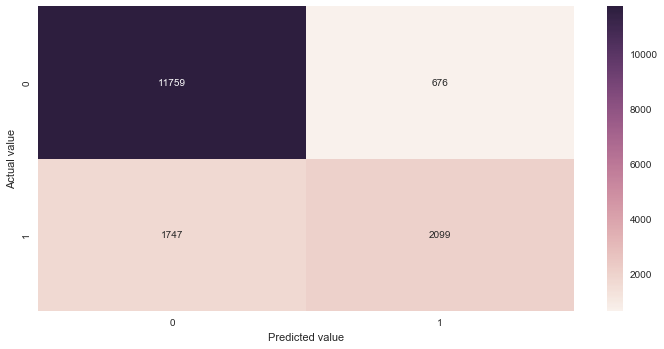

In [55]:
clf = SVC(C=100.0, kernel='rbf', degree=3, gamma=0.01, coef0=0.0, 
          shrinking=True, probability=False, tol=0.001, cache_size=200, 
          class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovo', random_state=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cmat = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cmat, annot=True, fmt="d", xticklabels=training_encoders["Target"].classes_, yticklabels=training_encoders["Target"].classes_)
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
print("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print("Recall: %f" % skl.metrics.recall_score(y_test, y_pred))

## GAUSSIAN NB

F1 score: 0.435623
Accuracy score: 0.802653
Precision score: 0.671359
Recall: 0.322413


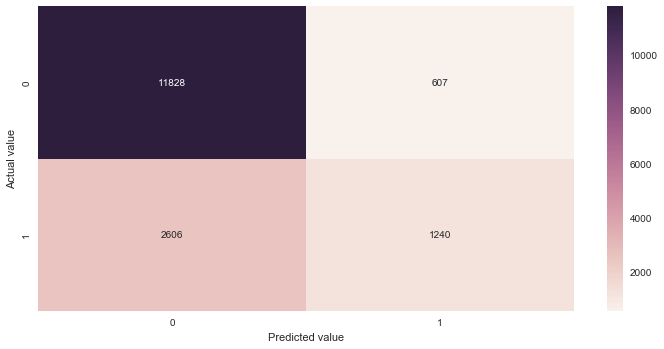

In [60]:
clf = GaussianNB()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cmat = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cmat, annot=True, fmt="d", xticklabels=training_encoders["Target"].classes_, yticklabels=training_encoders["Target"].classes_)
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
print("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print("Recall: %f" % skl.metrics.recall_score(y_test, y_pred))

## BERNOULLI NB

F1 score: 0.592381
Accuracy score: 0.807444
Precision score: 0.592458
Recall: 0.592304


C:\Users\mfarh\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


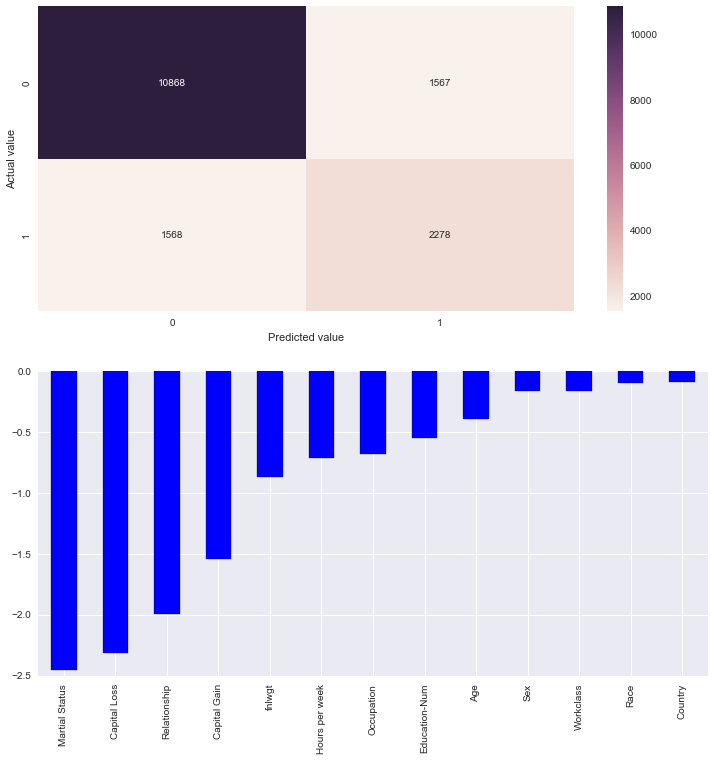

In [58]:
clf = BernoulliNB()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cmat = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cmat, annot=True, fmt="d", xticklabels=training_encoders["Target"].classes_, yticklabels=training_encoders["Target"].classes_)
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
print("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print("Recall: %f" % skl.metrics.recall_score(y_test, y_pred))
coeffs = pd.Series(clf.coef_[0], index=X_train.columns)
coeffs.sort()
plt.subplot(2,1,2)
coeffs.plot(kind="bar")
plt.show()

## ADABOOST CLASSIFER

F1 score: 0.671495
Accuracy score: 0.860697
Precision score: 0.758012
Recall: 0.602704


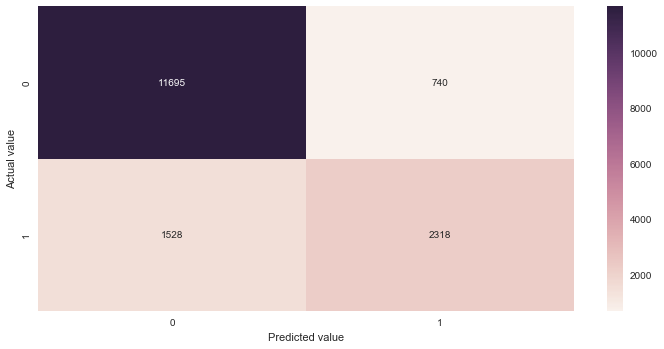

In [63]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cmat = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cmat, annot=True, fmt="d", xticklabels=training_encoders["Target"].classes_, yticklabels=training_encoders["Target"].classes_)
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
print("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print("Recall: %f" % skl.metrics.recall_score(y_test, y_pred))

# MODEL EVALUATIONS WITH IMPUTED MISSING VALUES

## Logistic Regression

In [120]:
cls = linear_model.LogisticRegression(penalty='l1', C=1.0)

cls.fit(X_train_imputed, y_train_imputed)
y_pred = cls.predict(X_test_imputed)
print('Logistic Regression')
print('*'*60)
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
print("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print("Recall: %f" % skl.metrics.recall_score(y_test, y_pred))

Logistic Regression
************************************************************
F1 score: 0.543542
Accuracy score: 0.826792
Precision score: 0.719983
Recall: 0.436557


## SVM

In [114]:
cls = SVC(C=100.0, kernel='rbf', degree=3, gamma=0.01, coef0=0.0, 
          shrinking=True, probability=False, tol=0.001, cache_size=200, 
          class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovo', random_state=5)
cls.fit(X_train_imputed, y_train_imputed)
y_pred = cls.predict(X_test_imputed)
print('SVC')
print('*'*60)
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
print("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print("Recall: %f" % skl.metrics.recall_score(y_test, y_pred))

SVC
************************************************************
F1 score: 0.622447
Accuracy score: 0.848965
Precision score: 0.760030
Recall: 0.527041


## GAUSSIAN NB

In [115]:
cls = GaussianNB()
cls.fit(X_train_imputed, y_train_imputed)
y_pred = cls.predict(X_test_imputed)
print('GaussianNB')
print('*'*60)
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
print("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print("Recall: %f" % skl.metrics.recall_score(y_test, y_pred))

GaussianNB
************************************************************
F1 score: 0.459704
Accuracy score: 0.805233
Precision score: 0.666831
Recall: 0.350754


## BERNOULLI NB

In [116]:
cls = BernoulliNB()
cls.fit(X_train_imputed, y_train_imputed)
y_pred = cls.predict(X_test_imputed)
print('BernoulliNB')
print('*'*60)
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
print("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print("Recall: %f" % skl.metrics.recall_score(y_test, y_pred))

BernoulliNB
************************************************************
F1 score: 0.580993
Accuracy score: 0.766292
Precision score: 0.503916
Recall: 0.685907


## ADABOOST CLASSIFER

In [117]:
cls = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
cls.fit(X_train_imputed, y_train_imputed)
y_pred = cls.predict(X_test_imputed)
print('AdaBoostClassifier')
print('*'*60)
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
print("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print("Recall: %f" % skl.metrics.recall_score(y_test, y_pred))

AdaBoostClassifier
************************************************************
F1 score: 0.666764
Accuracy score: 0.860205
Precision score: 0.763070
Recall: 0.592044
